In [1]:
import os

from typing import Annotated, Literal, TypedDict

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

In [2]:
import random

# 定义一个tools给agent使用
@tool
def search(query: str):
    """查询城市的天气"""
    print("模拟互联网请求，调用search tools query value is: {}".format(query))
    if "北京" in query:
        return ["北京温度8°"]
    elif "深圳" in query:
        return ["深圳温度32°"]
    else:
        return ["{}温度是{}°".format(query, random.randint(5, 35))]

In [3]:
tools = [search]
tool_node = ToolNode(tools)

In [4]:
model_name = "qwen2.5:7b"
ollama_api_base = os.environ["OLLAMA_API_BASE"]
model = init_chat_model(model=model_name, model_provider="ollama", base_url=ollama_api_base).bind_tools(tools)

In [5]:

def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    print("should_continue messages length:{}".format(len(messages)))
    
    last_message = messages[-1]
    if last_message.tool_calls:
        print("return tools")
        return "tools"
    return END

In [6]:
# 定义一个函数去调用model
def call_model(state: MessagesState):
    messages = state["messages"]
    print("call_model messages length:{}".format(len(messages)))
    response = model.invoke(messages)
    return {"messages": [response]}

In [7]:
# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set entrypoint as agent
# 这意味着，这个设置的节点会是第一个被调用的
workflow.set_entry_point("agent")

# 现在还需要添加conditional edge
workflow.add_conditional_edges(
    # 首先定义开始节点为agent
    "agent",
    # 然后，判断接下来的执行流程
    should_continue,
)

In [8]:
# 定义普通的边：调用完tools之后，总是调用下一个agent节点，这样图就构建完成了
workflow.add_edge("tools", "agent")

# 初始化检查点
checkpointer = MemorySaver()

# 把定义的检查点，传递给workflow, 这样完成了graph应用：app
app = workflow.compile(checkpointer=checkpointer)

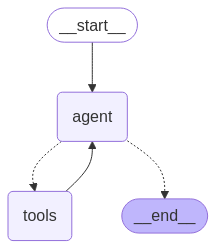

In [9]:
app

In [10]:
# 使用app
final_state = app.invoke(
    {"messages": [HumanMessage(content="最适合新手学习的编程语言是什么?")]},
    config={"configurable": {"thread_id": 123}}
)
print("\n")
print(final_state["messages"][-1].content)

call_model messages length:1
should_continue messages length:2


对于编程初学者来说，选择一门易于上手且具有良好社区支持的语言非常重要。以下是几个推荐给新手学习的编程语言：

1. Python：Python 以其简洁明了的语法著称，是许多初学者的首选。它广泛应用于数据分析、人工智能等领域，并拥有丰富的资源和活跃的开发者社区。

2. JavaScript：如果你对网页开发感兴趣，JavaScript 是一个不错的选择。它不仅可以用于前端开发，还可以在服务器端使用（Node.js）以及构建各种应用程序。

3. Scratch：对于更年轻的学习者来说，Scratch 是一个图形化编程环境，可以帮助他们直观地理解编程概念。

4. Ruby：虽然不如 Python 那样流行，但 Ruby 也有它自己的优点。特别是如果你想学习一门语法简洁、易于阅读的语言时，Ruby 可能是一个不错的选择。

您可以根据个人兴趣和目标来选择最适合您的语言。如果您想了解更多信息或需要其他建议，请随时告诉我！


In [11]:
resp = app.invoke(
    {"messages": [HumanMessage(content="查询北京的天气?")]},
    config={"configurable": {"thread_id": 123}}
)
print("\n")
resp["messages"][-1].content

call_model messages length:3
should_continue messages length:4
return tools
模拟互联网请求，调用search tools query value is: 北京
call_model messages length:5
should_continue messages length:6




'当前北京的温度是8°C。请注意根据天气变化适时增减衣物。如有需要，我可以为您提供更多的天气信息或建议。'

In [12]:
resp02 = app.invoke(
    {"messages": [HumanMessage(content="查询深圳的天气?")]},
    config={"configurable": {"thread_id": 123}}
)
print("\n")
resp02["messages"][-1].content

call_model messages length:7
should_continue messages length:8
return tools
模拟互联网请求，调用search tools query value is: 深圳
call_model messages length:9
should_continue messages length:10




'当前深圳的温度是32°C。请做好防暑措施，注意保持水分补充和避免长时间在户外活动。如有需要，我可以为您提供更多的天气信息或建议。'

In [13]:
# 查询个其它温度，随机温度
resp03 = app.invoke(
    {"messages": [HumanMessage(content="查询上海的天气?")]},
    config={"configurable": {"thread_id": 123}}
)
print("\n")
resp03["messages"][-1].content

call_model messages length:11
should_continue messages length:12
return tools
模拟互联网请求，调用search tools query value is: 上海
call_model messages length:13
should_continue messages length:14




'当前上海的温度是15°C。请根据天气适当增减衣物，保持舒适。如有需要，我可以为您提供更多的天气信息或建议。'